In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
churn_data = pd.read_excel('data/Telecom Churn Rate Dataset.xlsx')
call_data = pd.read_excel('data/Telecom Company Call-Center-Dataset.xlsx')

In [4]:
churn_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,One year,No,Mailed check,56.95,1889.5,0,0,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,0,0,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,3,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,0,0,Yes


### EDA

In [5]:
churn_data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
numAdminTickets       int64
numTechTickets        int64
Churn                object
dtype: object

In [6]:
def plot_vs_churn(col_name_1):
    
    # group the data by 'Churn' and 'gender'
    grouped = churn_data.groupby(['Churn', col_name_1]).size()

    # unstack the groupby object and plot it as a bar chart
    grouped.unstack().plot(kind='bar')

    # set the labels for the axes and the title of the plot
    # plt.figure(figsize=(10, 10))

    plt.xlabel('Churn')
    plt.ylabel(col_name_1)
    plt.title(f'Churn vs. {col_name_1}')

    # show the plot
    plt.show()


In [7]:
object_cols = list(churn_data.select_dtypes(include='object').columns)
object_cols.remove('customerID')
object_cols.remove('Churn')
object_cols.remove('TotalCharges')

In [8]:
object_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

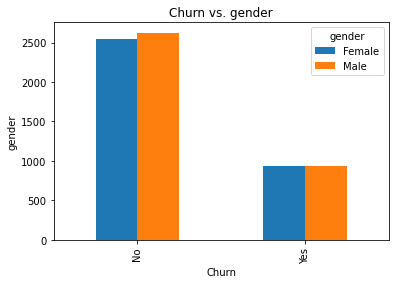

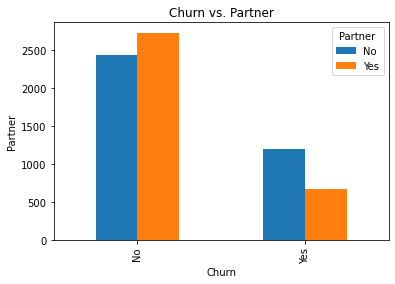

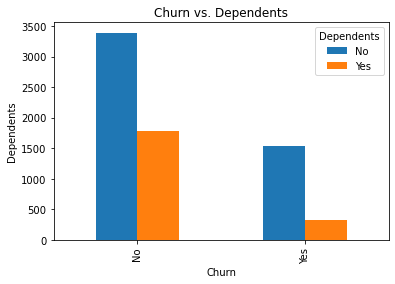

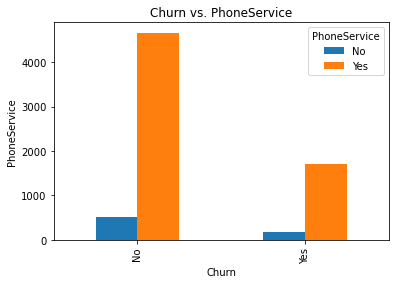

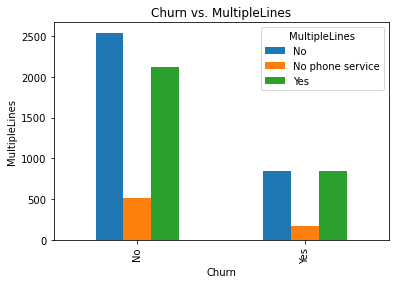

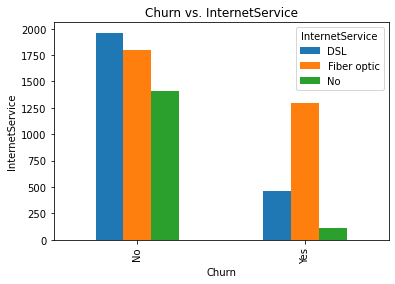

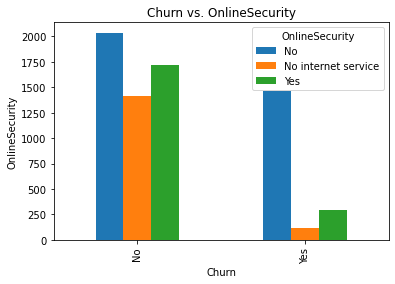

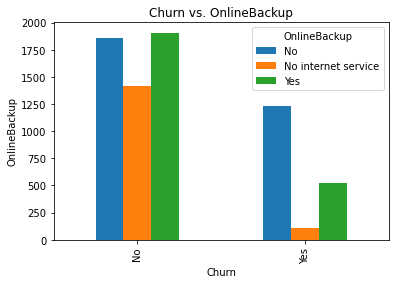

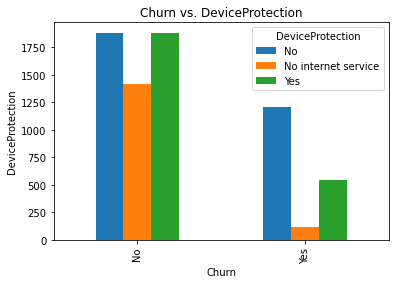

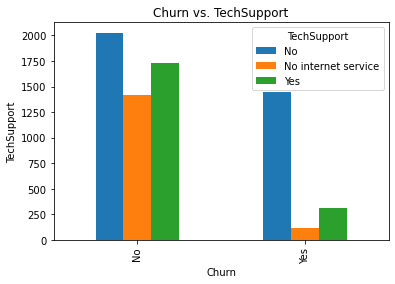

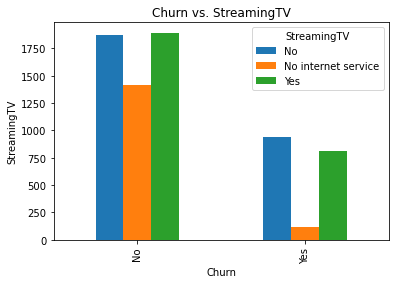

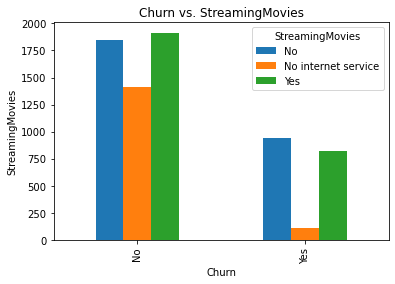

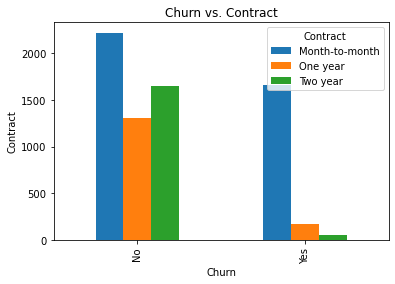

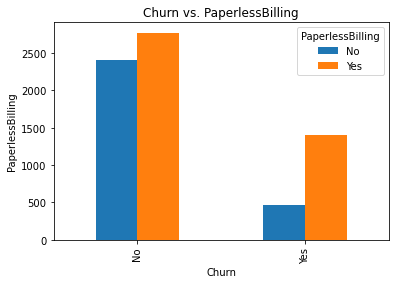

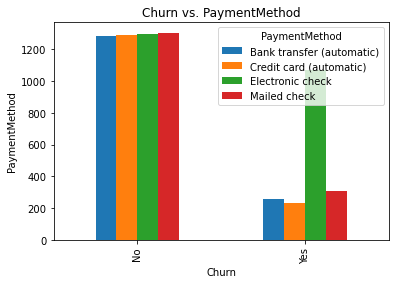

In [9]:
for col in object_cols:
    plot_vs_churn(col)

In [10]:
col_list = ["Partner","Dependents", "PhoneService", "PaperlessBilling", "Churn"]

for col in col_list:
    churn_data[col].replace({"Yes":1, "No":0}, inplace=True)


##### One Hot Encoding

In [11]:
churn_data["gender"].replace(["Female", "Male"], [0,1], inplace=True)

col_list = ["Partner","Dependents", "PhoneService", "PaperlessBilling", "Churn"]

for col in col_list:
    churn_data[col].replace({"Yes":1, "No":0}, inplace=True)


In [12]:
churn_cat = ["MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaymentMethod"]

def categorical_converter(column_name, main_df, cat_df):

    hot_encoder = OneHotEncoder()
    encoded_cat = hot_encoder.fit_transform(main_df[[column_name]]).toarray()
    encoded_df = pd.DataFrame(encoded_cat, columns = hot_encoder.get_feature_names_out())
    return pd.concat([cat_df,encoded_df], axis = 1)


In [13]:
cat_df = pd.DataFrame()

for categorical_column in churn_cat:
    cat_df = categorical_converter(categorical_column, churn_data, cat_df)


In [14]:
churn_data = pd.concat([churn_data, cat_df], axis = 1).drop(churn_cat, axis=1)

In [15]:
churn_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,0,0,1,0,1,0,1,29.85,29.85,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,5575-GNVDE,1,0,0,0,34,1,0,56.95,1889.5,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,3668-QPYBK,1,0,0,0,2,1,1,53.85,108.15,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,7795-CFOCW,1,0,0,0,45,0,0,42.30,1840.75,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,9237-HQITU,0,0,0,0,2,1,1,70.70,151.65,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [16]:
churn_data["TotalCharges"].replace(" ", pd.np.nan, inplace=True)
churn_data = churn_data.dropna()

In [17]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 44 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   customerID                               7032 non-null   object 
 1   gender                                   7032 non-null   int64  
 2   SeniorCitizen                            7032 non-null   int64  
 3   Partner                                  7032 non-null   int64  
 4   Dependents                               7032 non-null   int64  
 5   tenure                                   7032 non-null   int64  
 6   PhoneService                             7032 non-null   int64  
 7   PaperlessBilling                         7032 non-null   int64  
 8   MonthlyCharges                           7032 non-null   float64
 9   TotalCharges                             7032 non-null   float64
 10  numAdminTickets                          7032 no

##### Model Selection

In [18]:
X = churn_data.drop(["customerID","Churn"], axis=1).values
y = churn_data["Churn"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

bootstrap = [True, False]

random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

In [20]:
rnd_clf = RandomForestClassifier()

rnd_clf_cv = RandomizedSearchCV(

    estimator = rnd_clf, 
    param_distributions = random_grid, 
    n_iter = 100, 
    cv = 3, 
    verbose=2, 
    random_state=42, 
    n_jobs = -1,
    refit=True

)


rnd_clf.fit(X_train, y_train)

RandomForestClassifier()

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error

y_pred = rnd_clf.predict(X_test)

In [22]:
np.sqrt(mean_squared_error(y_test, y_pred))

0.3888249402021722

In [23]:
rnd_clf.score(X_test, y_test)

0.8488151658767773

In [24]:
rnd_clf_cv.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [25]:
rnd_clf_cv.best_params_

{'n_estimators': 1600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [26]:
rnd_clf = RandomForestClassifier(n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features="auto", 
                                 max_depth=10, bootstrap=True)

In [28]:
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features='auto', min_samples_split=5,
                       n_estimators=1600)

In [29]:
y_pred = rnd_clf.predict(X_test)

In [30]:
np.sqrt(mean_squared_error(y_test, y_pred))

0.38391843525534164

In [31]:
rnd_clf.score(X_test, y_test)

0.85260663507109

In [32]:
rnd_clf_cv = RandomizedSearchCV(

    estimator = rnd_clf, 
    param_distributions = random_grid, 
    n_iter = 100, 
    cv = 5,  
    random_state=42, 
    n_jobs = -1,
    refit=True

)

In [33]:
rnd_clf_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(max_depth=10,
                                                    max_features='auto',
                                                    min_samples_split=5,
                                                    n_estimators=1600),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42)

In [34]:
rnd_clf_cv.best_params_

{'n_estimators': 1000,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [35]:
rnd_clf = RandomForestClassifier(n_estimators=1000, min_samples_split=10, min_samples_leaf=2, max_features="sqrt", 
                                 max_depth=10, bootstrap=True)

In [36]:
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=1000)

In [37]:
y_pred = rnd_clf.predict(X_test)

In [39]:
np.sqrt(mean_squared_error(y_test, y_pred))

0.38081976929049316

In [40]:
rnd_clf.score(X_test, y_test)

0.8549763033175355

In [43]:
rnd_clf_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(max_depth=10,
                                                    max_features='auto',
                                                    min_samples_split=5,
                                                    n_estimators=1600),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42)

In [44]:
rnd_clf_cv.best_params_

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': True}

In [45]:
rnd_clf = RandomForestClassifier(n_estimators=600, min_samples_split=2, min_samples_leaf=4, 
                                 max_features="auto", max_depth=40, bootstrap=True)

In [46]:
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=40, max_features='auto', min_samples_leaf=4,
                       n_estimators=600)

In [48]:
y_pred = rnd_clf.predict(X_test)

In [49]:
np.sqrt(mean_squared_error(y_test, y_pred))

0.3876041367486221

In [50]:
rnd_clf.score(X_test, y_test)

0.8497630331753554